# Term2 Sprint25 授業課題 
## コーディング課題：Seq2Seq

## 1. 機械翻訳の実行とコードリーディング
Keras公式のサンプルコードで、短い英語からフランス語への変換が行えるのでこれを動かす。

[keras/lstm_seq2seq.py at master · keras-team/keras](https://github.com/keras-team/keras/blob/master/examples/lstm_seq2seq.py "keras/lstm_seq2seq.py at master · keras-team/keras")

その上でこのサンプルコードの各部分がどういった役割かを読み取り、まとめる。  
以下のようにどこからどこの行が何をしているかを記述する。

（例）

- 51から55行目 : ライブラリのimport
- 57から62行目 : ハイパーパラメータの設定


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

import os
os.chdir("/content/gdrive/My Drive/Colab Notebooks/")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
from __future__ import print_function

from keras.models import Model
from keras.layers import Input, LSTM, Dense
import numpy as np

batch_size = 64
epochs = 100
latent_dim = 256  # エンコーディング用のベクトル次元数
num_samples = 10000  # 訓練データサンプル数
data_path = 'fra-eng/fra.txt'

# データのベクトル化
input_texts = []
target_texts = []
input_characters = set()
target_characters = set()
# データを読み込み、改行位置で区切る
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
# データを1行ずつ取り出す
for line in lines[: min(num_samples, len(lines) - 1)]:
    # 1行の中でタブ位置で区切る
    input_text, target_text = line.split('\t')
    # タブ位置をtarget(フランス語)の始まり、改行位置を終わりとする
    target_text = '\t' + target_text + '\n'
    # input(英語)とtarget(フランス語)をリストに格納
    input_texts.append(input_text)
    target_texts.append(target_text)
    # inputとtargetの各単語が新出であれば各セットに記憶しておく
    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)
    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

# 単語セットをソート
input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
# 単語セットの単語数を生成
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
# 各行のテキストの長さのうち最大値を取得
max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

print('Number of samples:', len(input_texts))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

# 出現単語にindexを付与する辞書を作成
input_token_index = dict(
    [(char, i) for i, char in enumerate(input_characters)])
target_token_index = dict(
    [(char, i) for i, char in enumerate(target_characters)])

# テキストのベクトル化のためのゼロ配列を生成
encoder_input_data = np.zeros(
    (len(input_texts), max_encoder_seq_length, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(input_texts), max_decoder_seq_length, num_decoder_tokens),
    dtype='float32')

# ゼロ配列中に置いて、各テキスト中の出現単語に相当する場所を1.に変える
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        # decorder_target_dataはdecoder_input_dataに対して1ステップ先に格納
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            # 1ステップ先に格納し、初めの単語は含めない
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.

# インプット配列を定義し、LSTMのencoderを生成
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# LSTMの隠れ層と状態だけ保持
encoder_states = [state_h, state_c]

# 上記の`encoder_states`を初期状態としてdecoderを生成
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# decoderは出力配列全文と状態を返す。状態は訓練では使わないが予測で使う。
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# `encoder_input_data`と`decoder_input_data`で`decoder_target_data`を出力するモデルを生成
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

# 訓練開始
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size,
          epochs=epochs,
          validation_split=0.2)
# モデルの保存
model.save('s2s.h5')

# 予測 (サンプリング)
# 1) inputデータをencodeし、decoder用の初期状態を抽出
# 2) この状態でdecoderを1ステップ走らせ、targetとしての開始トークンを生成
# 3) 現在のtargetトークンと状態を使って繰り返す

# サンプリングモデルを定義
encoder_model = Model(encoder_inputs, encoder_states)

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
# decoderの状態と、decoderの出力を訓練済の全結合層に通した出力を生成
decoder_outputs, state_h, state_c = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
# 入力(入力データと状態)と出力(出力データと状態)をモデルとしてまとめる
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs] + decoder_states)

# インデックスから単語に紐付ける辞書を生成
reverse_input_char_index = dict(
    (i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict(
    (i, char) for char, i in target_token_index.items())


def decode_sequence(input_seq):
    # 入力データを状態ベクトルに予測変換
    states_value = encoder_model.predict(input_seq)

    # targetのゼロ配列を生成
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # 開始文字の場所を1.に変更
    target_seq[0, 0, target_token_index['\t']] = 1.

    # バッチ数分をサンプリングループ
    # (単純に考えるため、ここではバッチサイズを1と考える)
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        # トークン、状態を出力
        output_tokens, h, c = decoder_model.predict(
            [target_seq] + states_value)

        # トークンから該当する単語を出力
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        # 最終的に出力するための文字列に加えていく
        decoded_sentence += sampled_char

        # 終了条件：改行文字に該当するまたは出力文字列が最大値に達する
        if (sampled_char == '\n' or
           len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # target配列を更新
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # 状態を更新
        states_value = [h, c]

    return decoded_sentence


for seq_index in range(100):
    # 文章を1行ずつ取り出して翻訳していく(ここでは訓練データを使用)
    input_seq = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(input_seq)
    print('-')
    print('Input sentence:', input_texts[seq_index])
    print('Decoded sentence:', decoded_sentence)

Number of samples: 10000
Number of unique input tokens: 70
Number of unique output tokens: 93
Max sequence length for inputs: 16
Max sequence length for outputs: 59
Train on 8000 samples, validate on 2000 samples
Epoch 1/100
8000/8000 [==============================] - 19s 2ms/step - loss: 0.9143 - val_loss: 0.9327
Epoch 2/100
8000/8000 [==============================] - 17s 2ms/step - loss: 0.7194 - val_loss: 0.7516
Epoch 3/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.6121 - val_loss: 0.6678
Epoch 4/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.5594 - val_loss: 0.6219
Epoch 5/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.5186 - val_loss: 0.5875
Epoch 6/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.4871 - val_loss: 0.5584
Epoch 7/100
8000/8000 [==============================] - 16s 2ms/step - loss: 0.4613 - val_loss: 0.5418
Epoch 8/100
8000/8000 [==============================] - 16

/usr/local/lib/python3.6/dist-packages/keras/engine/network.py:877: UserWarning: Layer lstm_6 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'lstm_5/while/Exit_2:0' shape=(?, 256) dtype=float32>, <tf.Tensor 'lstm_5/while/Exit_3:0' shape=(?, 256) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '


-
Input sentence: Go.
Decoded sentence: Va !

-
Input sentence: Hi.
Decoded sentence: Salut !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Run!
Decoded sentence: Courez !

-
Input sentence: Who?
Decoded sentence: Qui ?

-
Input sentence: Wow!
Decoded sentence: La aute  !

-
Input sentence: Fire!
Decoded sentence: Au feu !

-
Input sentence: Help!
Decoded sentence: À l'aide !

-
Input sentence: Jump.
Decoded sentence: Sautez.

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Stop!
Decoded sentence: Stop !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Wait!
Decoded sentence: Attends !

-
Input sentence: Go on.
Decoded sentence: Poursuivez !

-
Input sentence: Go on.
Decoded sentence: Poursuivez !

-
Input sentence: Go on.
Decoded sentence: Poursuivez !

-
Input sentence: Hello!
Decoded sentence: Bonjour !

-
Input sentence: Hello!
Decoded sentence: Bonjour !

-
Input se

## 2. イメージキャプショニングの学習済みモデルの実行
他の活用例としてイメージキャプショニングがある。画像に対する説明の文章を推定するタスクのこと。  
これは画像を入力し、時系列を出力するImage to Sequenceの手法によって行える。

[pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial](https://github.com/yunjey/pytorch-tutorial/tree/master/tutorials/03-advanced/image_captioning "pytorch-tutorial/tutorials/03-advanced/image_captioning at master · yunjey/pytorch-tutorial")

イメージキャプショニングは学習に多くの時間がかかるため、ここでは学習済みの重みが公開されている実装を動かすことにする。  
Kerasには平易に扱える実装が公開されていないため、今回はPyTorchによる実装を扱う。

上記実装において5. Test the modelの項目を実行する。また、自身で用意した画像に対しても文章を生成する。  
これらに対してどういった文章が出力されたかを記録して提出する。

データセットからの学習は行わず、学習済みの重みをダウンロードして利用する。

注意点として、デフォルトで設定されている重みのファイル名と、ダウンロードできる重みのファイル名は異なっている。  
ここは書き換える必要がある。

In [0]:
!git clone https://github.com/pdollar/coco.git

Cloning into 'coco'...
remote: Enumerating objects: 953, done.
remote: Total 953 (delta 0), reused 0 (delta 0), pack-reused 953
Receiving objects: 100% (953/953), 11.70 MiB | 10.26 MiB/s, done.
Resolving deltas: 100% (565/565), done.


In [0]:
import os
os.chdir("coco/PythonAPI/")

In [0]:
!make

python setup.py build_ext --inplace
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/gdrive/My Drive/Colab Notebooks/coco/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-function -std=c99
../common/maskApi.c: In function ‘rle

In [0]:
!python setup.py build

running build
running build_py
creating build
creating build/lib.linux-x86_64-3.6
creating build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/__init__.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/coco.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/cocoeval.py -> build/lib.linux-x86_64-3.6/pycocotools
copying pycocotools/mask.py -> build/lib.linux-x86_64-3.6/pycocotools
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
building 'pycocotools._mask' extension
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/usr/include/python3.6m -c ../common/maskApi.c -o build/temp.linux-x86_64-3.6/../common/maskApi.o -Wno-cpp -Wno-unused-func

In [0]:
!python setup.py install

running install
running bdist_egg
running egg_info
creating pycocotools.egg-info
writing pycocotools.egg-info/PKG-INFO
writing dependency_links to pycocotools.egg-info/dependency_links.txt
writing requirements to pycocotools.egg-info/requires.txt
writing top-level names to pycocotools.egg-info/top_level.txt
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
writing manifest file 'pycocotools.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
running build_ext
skipping 'pycocotools/_mask.c' Cython extension (up-to-date)
creating build/bdist.linux-x86_64
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/__init__.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/coco.py -> build/bdist.linux-x86_64/egg/pycocotools
copying build/lib.linux-x86_64-3.6/pycocotools/cocoeval.py -> build/bdist.linux-x

In [0]:
os.chdir("../../")

In [0]:
!git clone https://github.com/yunjey/pytorch-tutorial.git

Cloning into 'pytorch-tutorial'...
remote: Enumerating objects: 816, done.
remote: Total 816 (delta 0), reused 0 (delta 0), pack-reused 816
Receiving objects: 100% (816/816), 12.78 MiB | 9.81 MiB/s, done.
Resolving deltas: 100% (432/432), done.


In [0]:
os.chdir("pytorch-tutorial/tutorials/03-advanced/image_captioning/")

In [0]:
!pwd

/content/gdrive/My Drive/Colab Notebooks/pytorch-tutorial/tutorials/03-advanced/image_captioning


In [0]:
!pip install -r requirements.txt

In [0]:
os.chdir("pytorch-tutorial/tutorials/03-advanced/image_captioning/")
!chmod +x download.sh

pretrained modelをインストール

In [0]:
!unzip pretrained_model.zip -d models/

Archive:  pretrained_model.zip
  inflating: models/encoder-5-3000.pkl  
  inflating: models/decoder-5-3000.pkl  


In [0]:
!unzip vocap.zip -d data/

Archive:  vocap.zip
  inflating: data/vocab.pkl          


### example.pngで文章生成、画像表示

<start> a group of giraffes standing next to each other . <end>


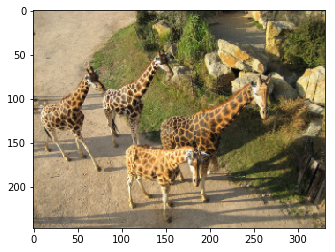

In [0]:
import cv2
from matplotlib import pyplot as plt

# 文章生成
# sample.pyのencoder_pathとdecoder_pathはpretrained_modelのpklファイル名に換装済
!python sample.py --image='png/example.png'

# 画像表示
img = cv2.imread('png/example.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

### 自分で用意した画像で文章生成、画像表示

<start> a red and white bus driving down a street . <end>


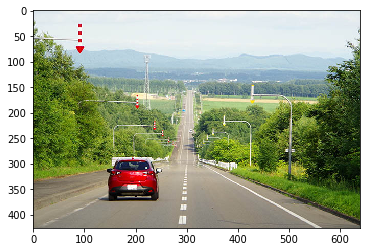

In [0]:
import cv2
from matplotlib import pyplot as plt

# 文章生成
# sample.pyのencoder_pathとdecoder_pathはpretrained_modelのpklファイル名に換装済
!python sample.py --image='png/car.png'

# 画像表示
img = cv2.imread('png/car.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

<start> a large wooden table with a clock on it . <end>


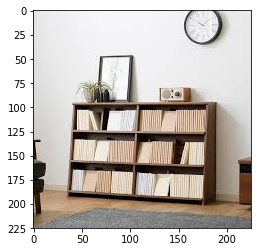

In [0]:
import cv2
from matplotlib import pyplot as plt

# 文章生成
# sample.pyのencoder_pathとdecoder_pathはpretrained_modelのpklファイル名に換装済
!python sample.py --image='png/bookshelf.png'

# 画像表示
img = cv2.imread('png/bookshelf.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

<start> a large white and black cat sitting on a table . <end>


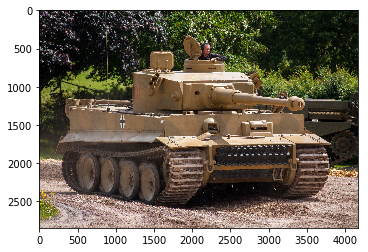

In [0]:
import cv2
from matplotlib import pyplot as plt

# 文章生成
# sample.pyのencoder_pathとdecoder_pathはpretrained_modelのpklファイル名に換装済
!python sample.py --image='png/tiger_tank.png'

# 画像表示
img = cv2.imread('png/tiger_tank.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

## 3. Kerasで動かしたい場合はどうするかを調査
PyTorchによる実装を動かしたが、何らかの理由からKerasで動かしたい状況が考えられる。  
どういった手順を踏むことになるか調査する。

特に今回はPyTorchのための学習済みの重みをKerasで使えるようにしたいので、その点については必ず触れる。

- model.pyのモデル構築において、EncoderCNNとDecoderRNNはtorchやtorchvisionを使用しているので、keras.layers等で全面的に書き換える必要がある。  
[KerasでSeq2Seqをやる](https://gist.github.com/GINK03/c2e9ce4a03254cb70ed0304a63cab072 "KerasでSeq2Seqをやる")

- 学習済の重みデータも含め、モデル全体を異なるライブラリ間でconvertする必要がある。  
[MMdnn](https://github.com/Microsoft/MMdnn "MMdnn")